In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sellin = pd.read_csv("datasets/sell-in.csv", sep='\t')
productos = pd.read_csv("datasets/tb_productos.csv", sep='\t')
stocks = pd.read_csv("datasets/tb_stocks.csv", sep='\t')

In [3]:
# Verificación inicial
print(f"Sell-In: {sellin.shape[0]} filas y {sellin.shape[1]} columnas")
print(f"Productos: {productos.shape[0]} filas y {productos.shape[1]} columnas")
print(f"Stocks: {stocks.shape[0]} filas y {stocks.shape[1]} columnas")

Sell-In: 2945818 filas y 7 columnas
Productos: 1262 filas y 6 columnas
Stocks: 13691 filas y 3 columnas


In [4]:
# 3. MERGE INICIAL
df = sellin.merge(productos, on="product_id", how="left")
df = df.merge(stocks, on=["product_id", "periodo"], how="left")
print(f"Ventas-Productos-Stocks: {df.shape[0]} filas y {df.shape[1]} columnas")

Ventas-Productos-Stocks: 2988650 filas y 13 columnas


In [5]:
productos_clean = productos.drop_duplicates(subset=['product_id'], keep='first')
print(productos_clean.shape)

(1251, 6)


In [6]:
df = sellin.merge(productos_clean, on="product_id", how="left")
df = df.merge(stocks, on=["product_id", "periodo"], how="left")
print(sellin.shape)
print(df.shape)

(2945818, 7)
(2945818, 13)


In [7]:
df['periodo_dt'] = pd.to_datetime(df['periodo'].astype(str), format='%Y%m')

In [8]:
df.columns

Index(['periodo', 'customer_id', 'product_id', 'plan_precios_cuidados',
       'cust_request_qty', 'cust_request_tn', 'tn', 'cat1', 'cat2', 'cat3',
       'brand', 'sku_size', 'stock_final', 'periodo_dt'],
      dtype='object')

# Cantidad de Clientes

In [15]:
df['customer_id'].nunique()

597

# Clientes con más compras (cantidad de registros)

In [12]:
# Cantidad de registros por cliente
compras_por_cliente = df['customer_id'].value_counts().reset_index()
compras_por_cliente.columns = ['customer_id', 'cantidad_de_compras']

# Mostrar top 10
display(compras_por_cliente.head(10))

,customer_id,cantidad_de_compras
0,10001,24914
1,10004,24234
2,10003,23927
3,10007,23257
4,10002,23224
5,10018,22461
6,10027,22395
7,10059,21783
8,10005,21189
9,10034,19506


# Clientes que más toneladas compraron

In [17]:
# Volumen total por cliente
tn_por_cliente = (
    df.groupby('customer_id')['tn']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

tn_por_cliente.columns = ['customer_id', 'total_toneladas']
display(tn_por_cliente.head(10))


,customer_id,total_toneladas
0,10001,109203.60059
1,10002,77333.16887
2,10003,71375.91941
3,10004,63065.94269
4,10005,51467.04585
5,10006,49779.23364
6,10007,43740.39629
7,10008,41962.99046
8,10009,38742.71591
9,10011,34675.44337


In [16]:
# Juntar ambas tablas
top_clientes = compras_por_cliente.merge(tn_por_cliente, on='customer_id')

# Ordenar por toneladas
top_clientes = top_clientes.sort_values(by='total_toneladas', ascending=False)

display(top_clientes.head(10))

,customer_id,cantidad_de_compras,total_toneladas
0,10001,24914,109203.60059
4,10002,23224,77333.16887
2,10003,23927,71375.91941
1,10004,24234,63065.94269
8,10005,21189,51467.04585
15,10006,18077,49779.23364
3,10007,23257,43740.39629
98,10008,9028,41962.99046
24,10009,16415,38742.71591
18,10011,17019,34675.44337


C:\Users\iparra\AppData\Local\Temp\ipykernel_21224\364771763.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


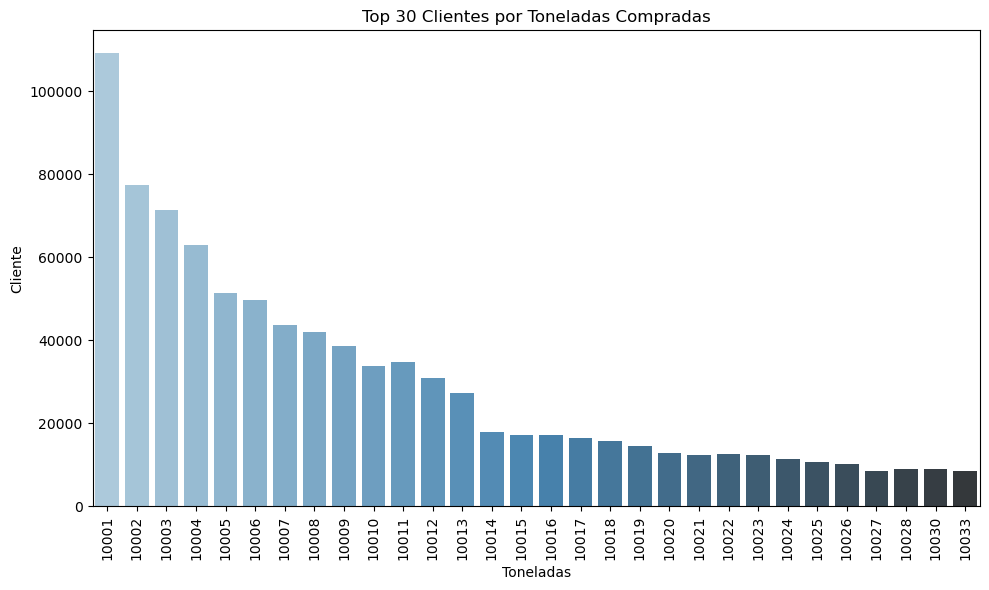

In [25]:
top_n = 30
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_clientes.head(top_n),
    x='customer_id',
    y='total_toneladas',
    palette='Blues_d'
)
plt.title(f"Top {top_n} Clientes por Toneladas Compradas")
plt.xlabel("Toneladas")
plt.ylabel("Cliente")
plt.xticks(rotation=90)  # 👈 Rotar etiquetas del eje X
plt.tight_layout()
plt.show()


# Stock Final

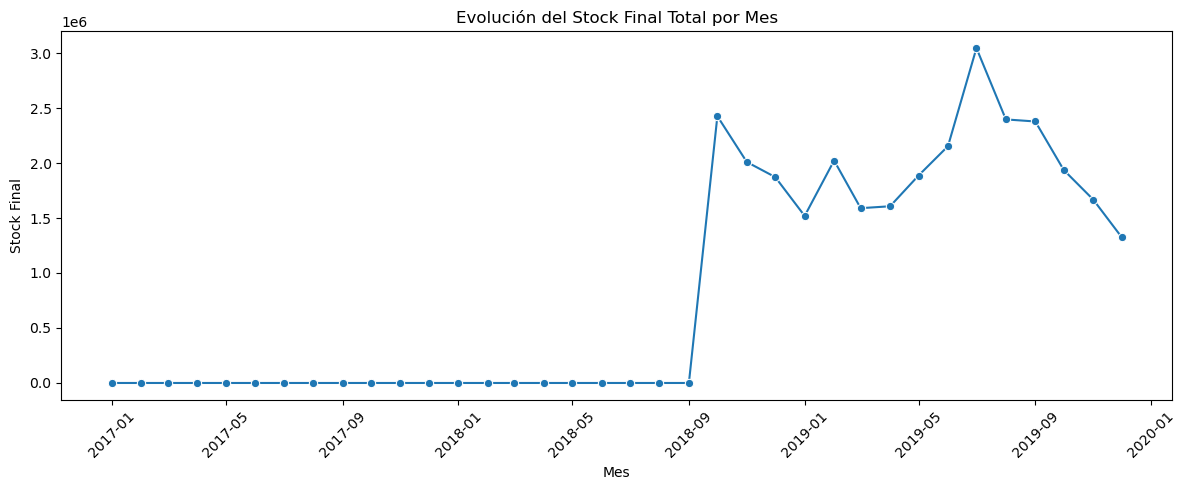

In [32]:
# Asegurar que 'periodo' esté en datetime
df['periodo_dt'] = pd.to_datetime(df['periodo'].astype(str), format='%Y%m')

# Agrupar por mes
stock_mensual = df.groupby('periodo_dt')['stock_final'].sum().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=stock_mensual, x='periodo_dt', y='stock_final', marker='o')
plt.title("Evolución del Stock Final Total por Mes")
plt.xlabel("Mes")
plt.ylabel("Stock Final")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Precios Cuidados

##### Cantidad de productos incluidos en precios cuidados

In [42]:
aux = df[df['plan_precios_cuidados'] == 1]
print(f"Total de productos en precios cuidades: {aux['product_id'].nunique()}")
print(f"Representa un {round(aux['product_id'].nunique()*100/df['product_id'].nunique(),2)}% del total de productos.")

Total de productos en precios cuidades: 42
Representa un 3.41% del total de productos.


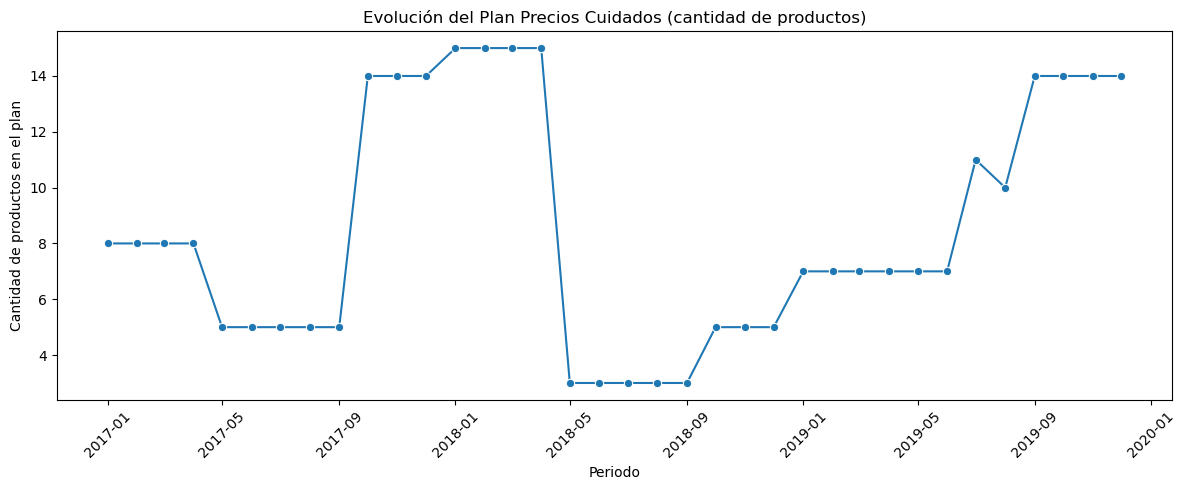

In [34]:
# Asegurar formato datetime
df['periodo_dt'] = pd.to_datetime(df['periodo'].astype(str), format='%Y%m')

# Agrupar y contar cuántos productos estuvieron en el plan por mes
evolucion_precios_cuidados = (
    df[df['plan_precios_cuidados'] == 1]
    .groupby('periodo_dt')['product_id']
    .nunique()
    .reset_index(name='productos_en_plan')
)

# Graficar
plt.figure(figsize=(12, 5))
sns.lineplot(data=evolucion_precios_cuidados, x='periodo_dt', y='productos_en_plan', marker='o')
plt.title("Evolución del Plan Precios Cuidados (cantidad de productos)")
plt.xlabel("Periodo")
plt.ylabel("Cantidad de productos en el plan")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Target


### 🎯 **Objetivo del modelo:**

Predecir, el **día 2 del mes `M`**, cuántas **toneladas (tn)** se van a vender de cada producto durante el mes `M+2`.

---

### 🧠 ¿Qué implica eso?

Significa que tu modelo solo puede usar **información disponible hasta el cierre de mes `M-1`** para predecir el **target de `M+2`**.

---

### 🏷️ ¿Cómo calcular la `target`?

```python
df['target_tn_mes_mas2'] = (
    df.groupby('product_id')['tn']
    .shift(-2)  # Porque querés predecir el mes M+2 desde M
)
```

---

### ✅ Ejemplo concreto

* Si hoy es **1 de mayo**, y el mes de corte fue abril (`periodo = 201804`)
* Tu modelo debe usar como último dato válido todo lo ocurrido hasta abril (`201804`)
* Y debe predecir las toneladas que se venderán en junio (`201806`)
* Entonces tu target será: `tn` del periodo `201806`

---

### 🔁 Validación temporal (muy importante)

Para evitar fuga de información (**data leakage**), tu validación debe ser **time-based**: entrenar en meses anteriores, y testear solo en períodos futuros (por ejemplo, entrenamiento hasta 2020 y predicción para 2021).

---

### 📦 Dataset final: ejemplo de estructura

| product\_id | periodo | ...features... | target\_tn\_mes\_mas2 |
| ----------- | ------- | -------------- | --------------------- |
| 1001        | 202101  | ...            | 23.5                  |
| 1001        | 202102  | ...            | 19.8                  |
| 1001        | 202103  | ...            | 22.1                  |
| ...         | ...     | ...            | ...                   |

---

### 📌 Siguiente paso: ¿Querés que te ayude a generar las **features temporales** para el modelo (lags, rolling mean, etc.)? O incluso a armar el **pipeline completo** para training y predicción.

----------

Excelente pregunta. Estás tocando un punto **clave**: el dataset está a nivel **producto–cliente–mes**, pero tu predicción necesita estar a nivel **producto–mes**.

---

### 🎯 ¿Qué necesitamos?

Predecir la cantidad de **toneladas vendidas** por producto en el **mes+2**.

---

### 🧩 Paso 1: **Agregación por producto y mes**

Como la predicción es **por producto**, no te sirve la granularidad cliente-producto. Tenés que **agregar las ventas totales de cada producto por mes**:

```python
# Asegurar que 'periodo' sea string o int para orden
df['periodo'] = df['periodo'].astype(int)

# Agregación por producto y mes
ventas_mensuales = (
    df.groupby(['product_id', 'periodo'])['tn']
    .sum()
    .reset_index()
    .sort_values(['product_id', 'periodo'])
)
```

Ahora tenés un dataset con este formato:

| product\_id | periodo | tn   |
| ----------- | ------- | ---- |
| 1001        | 202101  | 32.5 |
| 1001        | 202102  | 18.2 |
| 1002        | 202101  | 5.0  |
| ...         | ...     | ...  |

---

### 🧩 Paso 2: **Crear la variable `target`**

Ahora podés crear fácilmente la `target_tn_mes_mas2`:

```python
ventas_mensuales['target_tn_mes_mas2'] = (
    ventas_mensuales.groupby('product_id')['tn']
    .shift(-2)
)
```

---

### 🧠 ¿Qué características (`features`) podés usar?

Podés enriquecer el dataset con features derivadas de la serie de tiempo, como:

#### 📌 Lags:

```python
ventas_mensuales['lag_1'] = ventas_mensuales.groupby('product_id')['tn'].shift(1)
ventas_mensuales['lag_2'] = ventas_mensuales.groupby('product_id')['tn'].shift(2)
ventas_mensuales['lag_3'] = ventas_mensuales.groupby('product_id')['tn'].shift(3)
```

#### 📌 Medias móviles:

```python
ventas_mensuales['rolling_3_mean'] = (
    ventas_mensuales.groupby('product_id')['tn']
    .shift(1)
    .rolling(window=3)
    .mean()
    .reset_index(level=0, drop=True)
)
```

#### 📌 Estacionalidad:

Extraer mes para capturar patrones de estacionalidad:

```python
ventas_mensuales['periodo_dt'] = pd.to_datetime(ventas_mensuales['periodo'].astype(str), format='%Y%m')
ventas_mensuales['mes'] = ventas_mensuales['periodo_dt'].dt.month
```

---

### ✅ Resultado final: dataset a nivel `producto–mes`

Con columnas como:

| product\_id | periodo | tn | lag\_1 | lag\_2 | rolling\_3\_mean | mes | target\_tn\_mes\_mas2 |
| ----------- | ------- | -- | ------ | ------ | ---------------- | --- | --------------------- |

---

### 🔮 ¿Cómo predecir?

Ahora podés:

* Usar modelos de **machine learning supervisado** (XGBoost, LightGBM, etc.) sobre ese dataset.
* O bien, generar una **serie de tiempo individual por producto** y aplicar modelos como:

  * ARIMA
  * Prophet
  * LightGBM con `TimeSeriesSplit`
  * Exponential smoothing
  * etc.

Pero lo importante es que **toda la lógica y preparación se hace sobre el dataset agregado a nivel producto–mes**.

---

### ¿Querés que te genere el pipeline en código con `LightGBM`, `Optuna` o similar? ¿O que prepare una versión de series por producto con Prophet o SARIMA?


In [58]:
# Asegurar que 'periodo' sea string o int para orden
df['periodo'] = df['periodo'].astype(int)

#🧩 Paso 1: Agregación por producto y mes
ventas_mensuales = (
    df.groupby(['product_id', 'periodo'])['tn']
    .sum()
    .reset_index()
    .sort_values(['product_id', 'periodo'])
)

# 🧩 Paso 2: Crear la variable target
ventas_mensuales['target_tn_mes_mas2'] = (
    ventas_mensuales.groupby('product_id')['tn']
    .shift(-2)
)

In [60]:
ventas_mensuales[ventas_mensuales['product_id']==20001]

,product_id,periodo,tn,target_tn_mes_mas2
0,20001,201701,934.77222,1303.35771
1,20001,201702,798.01620,1069.96130
2,20001,201703,1303.35771,1502.20132
3,20001,201704,1069.96130,1520.06539
4,20001,201705,1502.20132,1030.67391
5,20001,201706,1520.06539,1267.39462
6,20001,201707,1030.67391,1316.94604
7,20001,201708,1267.39462,1439.75563
8,20001,201709,1316.94604,1580.47401
9,20001,201710,1439.75563,1049.38860
